# Visualising HDF5-files

Finnish Meteorological Institute is providing radar images as GeoTiff and HDF5-files in S3 bucket. GeoTiff images contain processed data (typically from constant altitude) and HDF5-files raw radar volumes from single radars. The data is free and openly available with CC4BY license. Please consult https://en.ilmatieteenlaitos.fi/open-data for more information. 

This example illustrates few possible methods to access and process the HDF5-data with python. The example aims to help accessing and opening files provided by FMI. Related libraries and examples can be used to get more examples how to process the data. 

First, the environment. `gdal, dask, xarray, h5py, h5netcdf, tqdm` are required for these examples wradlib https://docs.wradlib.org/en/stable/) being the main library. These notebooks are created with Amazon Sagemaker and environment are setup with following commands:
```
yum install -y --enablerepo="epel" netcdf4-python gdal gdal-python
conda create -c conda-forge --name fmiopendata python=3.6 ipykernel gdal dask xarray h5py h5netcdf tqdm boto3 wradlib
python -m ipykernel install --user --name fmiopendata --display-name "fmiopendata"
conda env export --name fmiopendata --file ~/fmiopendata.yml
```

Rasterio (https://github.com/mapbox/rasterio) and pyproj (https://pypi.org/project/pyproj/) are used in GeoTiff example.

In [1]:
import xarray, h5py
import os, boto3
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axisartist.grid_finder import FixedLocator

from osgeo import gdal
import wradlib as wrl

Unfortunately wradlib has only partial support for remote files so we need to download processed files to local tmp directory. Following function will do:

In [2]:
def download(bucket_name, key, dst_root='/tmp'):
    """ Download file from S3 
        
        bucket_name : str 
        key         : str
        dst_root    : str
                      Where files are located, must exists. 
                      Possible folder structure in key is followed under this directory.     
                      
        Returns
        -------
        str
           local filename
    """
    s3 = boto3.resource('s3')
    
    bucket = s3.Bucket(bucket_name) 
    dst_filename = '{}/{}'.format(dst_root, key)
    
    for object in bucket.objects.filter(Prefix = key):
        dst = dst_root+'/'+object.key
        if not os.path.exists(os.path.dirname(dst)):
            os.makedirs(os.path.dirname(dst))
        s3.meta.client.download_file(bucket_name, key, dst_filename) 
    
    return dst_filename

Download some file of interest:

In [3]:
fname = download('fmi-opendata-radar-volume-hdf5', '2020/09/16/fikor/202009161735_fikor_POLARVOLUME.h5')

Let's first open the file with wradlib and see what we have here. `print(vol)` tells us that the file contain two sweeps with angles 1.5 and 3 degrees. With a command `print(vol[0].data` we can see geospatial and temporal dimensions of the first sweep. 

More detailed documentation can be found here: https://docs.wradlib.org/en/stable/notebooks/fileio/wradlib_xarray_radial_odim.html

In [4]:
vol = wrl.io.xarray.open_odim(fname, loader='h5py', chunks={})
print('Whole volume: \n{}\n'.format(vol))
print('First sweep as xarray: \n{}'.format(vol[0].data))

Collecting: 100%|██████████| 9/9 [00:00<00:00, 1100.87 Angles/s]
/home/ec2-user/anaconda3/envs/fmiopendata/lib/python3.6/site-packages/wradlib/io/xarray.py:2127: UserWarning: wradlib: Moments ['', 'DBZV', 'TV'] are not available in all datasets and will be dropped from the result.
This will be solved in xarray, see https://github.com/pydata/xarray/pull/3545
  "https://github.com/pydata/xarray/pull/3545".format(drop)
Collecting:  50%|█████     | 1/2 [00:00<00:00,  6.62 Timesteps/s]

Whole volume: 
<wradlib.XRadVolume>
Dimension(s): (sweep: 9)
Elevation(s): (0.5, 0.7, 1.5, 3.0, 5.0, 9.0, 4.0, 2.0, 0.4)



Collecting: 100%|██████████| 2/2 [00:00<00:00,  6.20 Timesteps/s]


First sweep as xarray: 
<xarray.Dataset>
Dimensions:      (azimuth: 360, range: 2500, time: 2)
Coordinates:
  * range        (range) float64 62.5 187.5 250.0 ... 2.498e+05 2.499e+05
  * time         (time) datetime64[ns] 2020-09-16T17:35:07 2020-09-16T17:38:18
  * azimuth      (azimuth) float32 0.5 1.5 2.5 3.5 ... 356.5 357.5 358.5 359.5
    elevation    (azimuth) float32 0.5 0.5 0.5 0.5 0.5 ... 0.5 0.5 0.5 0.5 0.5
    rtime        (time, azimuth) datetime64[ns] 2020-09-16T17:35:08.191668480...
    sweep_mode   <U20 'azimuth_surveillance'
    latitude     float64 60.13
    longitude    float64 21.64
    towerheight  float64 26.0
    altitude     float64 61.0
Data variables:
    DBZH         (time, azimuth, range) float32 dask.array<chunksize=(1, 360, 2500), meta=np.ndarray>
    DBZHC        (time, azimuth, range) float32 dask.array<chunksize=(1, 360, 2500), meta=np.ndarray>
    DBZX         (time, azimuth, range) float32 dask.array<chunksize=(1, 360, 2500), meta=np.ndarray>
    HCLASS 

We can also plot the sweeps. X and Y axis are just range from the radar.

Collecting: 100%|██████████| 1/1 [00:00<00:00,  6.75 Timesteps/s]


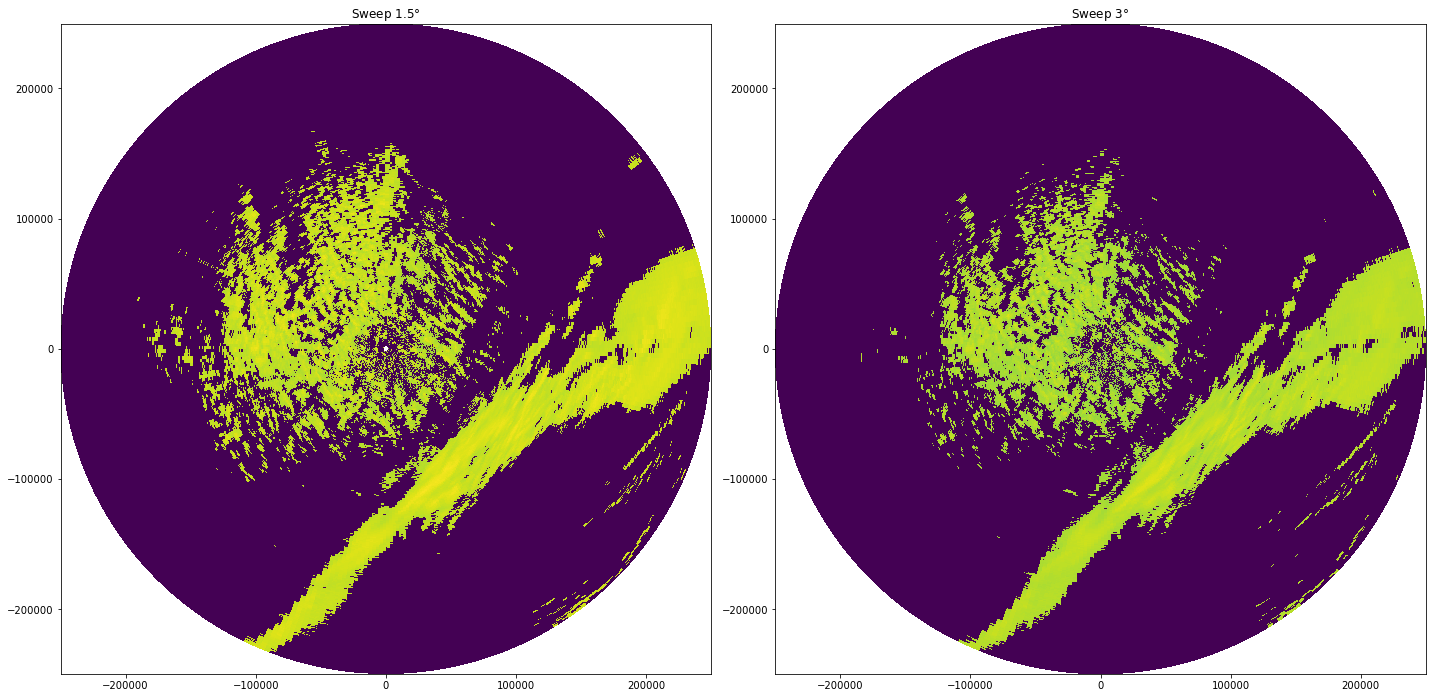

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(20,10))
vol[0].data.pipe(wrl.georef.georeference_dataset).DBZH[0].wradlib.plot(ax=axes[0])
vol[1].data.pipe(wrl.georef.georeference_dataset).DBZH[0].wradlib.plot(ax=axes[1])

axes[0].set_title(r'Sweep 1.5$\degree$')
axes[1].set_title(r'Sweep 3$\degree$')
plt.tight_layout()

We can plot PPI in WGS84 following:

Collecting: 100%|██████████| 1/1 [00:00<00:00,  6.79 Timesteps/s]


(<AxesSubplot:>, <matplotlib.collections.QuadMesh at 0x7f5398f13b70>)

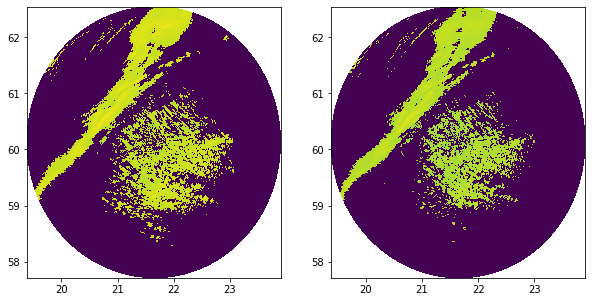

In [6]:
site = (vol[0].data.latitude.data, vol[0].data.longitude.data, vol[0].data.altitude.data)

epsg = wrl.georef.proj4_to_osr('+proj=longlat +datum=WGS84 +no_defs')

fig, axes = plt.subplots(1, 2, figsize=(10,10))
wrl.vis.plot_ppi(vol[0].data.DBZH[0], proj=epsg, site=site, r=vol[0].data.DBZH[0].range.data, ax=axes[0])
wrl.vis.plot_ppi(vol[1].data.DBZH[0], proj=epsg, site=site, r=vol[2].data.DBZH[0].range.data, ax=axes[1])

Next, we plot range height indicator

Collecting: 100%|██████████| 1/1 [00:00<00:00, 16.51 Timesteps/s]
/home/ec2-user/anaconda3/envs/fmiopendata/lib/python3.6/site-packages/xarray/plot/plot.py:987: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  primitive = ax.pcolormesh(x, y, z, **kwargs)


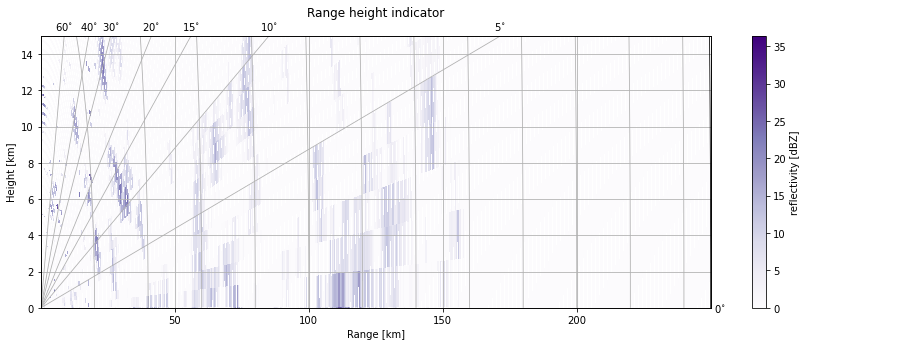

In [7]:
r = vol[0].data.DBZH[0].range.data
th = []
for sweep in vol:
    th.append(sweep.data.DBZH[0].elevation.data[0])

fig = plt.figure(figsize=(15,5))

ax, pm = wrl.vis.plot_rhi(vol[0].data.DBZH[0], r, vol[0].data.DBZH[0].azimuth.data, fig=fig, rf=1e3, proj='cg', cmap='Purples', vmin=0)

ax1 = ax.parasites[0]

ax.set_ylim(0, 15)
cbar = fig.colorbar(pm, pad=.05, ax=ax.parasites[1])

t = plt.title('Range height indicator', y=1.05)
cbar.set_label('reflectivity [dBZ]')
ax1.set_xlabel('Range [km]')
ax1.set_ylabel('Height [km]')

ax.get_grid_helper().grid_finder.grid_locator1 = FixedLocator([0., 5., 10., 15., 20., 30., 40., 60., 90.])

Please consult wradlib documentation (https://docs.wradlib.org/en/stable/index.html) for more information. On nice example can also be found at https://nbviewer.jupyter.org/github/IreneCrisologo/playground/blob/master/crossview.ipynb
